生成时间序列代码
格式：

A类物质含量  B类物质含量  入口温度	加热温度	入口压力	阀门开度	入口流速	出口温度	出口压力	出口流速	C类物质含量	D类物质含量	E类物质含量	A类物质含量	B类物质含量


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy.stats import pearsonr

import random
random.seed(715)

载入种子数据

In [3]:
d1 = dintemp = pd.read_csv('data/test_data1.csv')
d2 = dheattemp = pd.read_csv('data/test_data2.csv')
d3 = dinspeed = pd.read_csv('data/test_data3.csv')
d4 = dinrate = pd.read_csv('data/test_data4.csv')

df = pd.concat([d1, d2, d3, d4])
df = df.reset_index(drop=True)

In [4]:
#定义常量
FTR_COLS = ['InRateA', 'InTemp', 'HeatTemp', 'InSpeed']
VAL_COLS = ['OutTemp', 'OutPress', 'OutSpeed', 'OutRateC', 'OutRateD', 
            'OutRateE', 'OutRateA', 'OutRateB']


数据关系分析

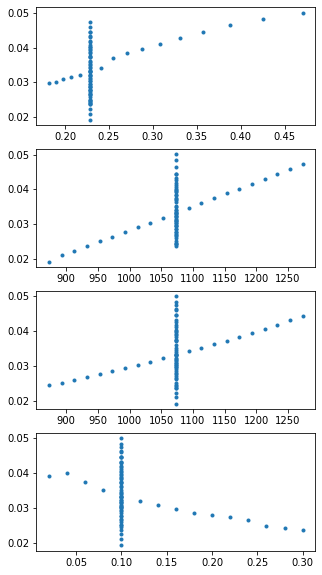

In [5]:
plt.subplots(figsize=(5,10))

for i, c in enumerate(FTR_COLS):
    plt.subplot(4,1,i+1)
    plt.plot(df[c], df.OutRateC, '.')

数据生成

In [6]:
#获取各个字段取值列表
def get_set_values(df, cols):
    return {c: list(set(df[c].values)) for c in cols}

#生成最常见的值列表
# def gen_common_vals(mid, num=12, dither_rate=0.1):
#     return np.random.randn(num) * dither_rate * mid + mid
def gen_common_vals(mid, dither_range=None, v_min=-np.inf, v_max=np.inf, num=50):
    if dither_range is None:
        dither_range = mid * 0.1
    cand_vals = np.random.randn(num) * dither_range + mid
    cand_vals[cand_vals < v_min] = mid
    cand_vals[cand_vals > v_max] = mid
    return cand_vals


#添加更常用的取值
def add_commons(stat_vals, common_vals):
    new_vals = {}
    for k in stat_vals:
        new_vals[k] = np.concatenate((stat_vals[k], common_vals[k]))
    return new_vals
    
    
#数组插值
def ar_interpolate(a, times=5, method='quadratic'):
    ix = np.arange(len(a))
    f = interp1d(ix, a, method)
    newx = np.linspace(0, len(a)-1, len(a)*times)
     
    newy = f(newx)
    dither_range =  newy.std() * 0.4
    #newy = newy * \
    #      np.array([dither_range * np.random.randn() + 1 for i in range(len(newx))])
    #newy = newy + [dither_range * np.random.randn() for i in range(len(newx))]
    
    return newx, newy


#数据噪声
def add_nois(a, error_range):
    return a + error_range * np.random.randn(len(a))

In [7]:
ftr_values = get_set_values(df, FTR_COLS)

mid_dict = {'InRateA': 0.228571, 
            'InTemp': 1050,
            'HeatTemp': 1070,
            'InSpeed': 0.099}

com_vals = {c: gen_common_vals(mid_dict[c], num=2) for c in mid_dict}
ftr_domains = {}
#ftr_domains = add_commons(ftr_values, com_vals)
#ftr_domains = {c: gen_common_vals(mid_dict[c], num=200) for c in mid_dict}
ftr_domains['InSpeed'] = gen_common_vals(0.099, num=200, v_min=0.01, v_max=0.3, 
                                         dither_range=0.1)

ftr_domains['InTemp'] = gen_common_vals(1050, num=200, v_min=980, v_max=1120, 
                                        dither_range=50)

ftr_domains['HeatTemp'] = gen_common_vals(1070, num=200, v_min=1000, v_max=1160, 
                                        dither_range=50)

ftr_domains['InRateA'] = gen_common_vals(0.23, num=200, v_min=0.15, v_max=0.5, 
                                        dither_range=0.1)


In [8]:
# sample_vals = {c: np.concatenate((np.random.choice(ftr_domains[c],8), com_vals[c][:2]))\
#              for c in ftr_cols}
                                
sample_vals = {c: np.random.choice(ftr_domains[c],10)\
              for c in ftr_domains}

full_vals = {c : ar_interpolate(sample_vals[c], times=100) \
             for c in sample_vals}

er_range = {'InRateA': 0.01, 
            'InTemp': 2,
            'HeatTemp': 2,
            'InSpeed': 0.008}

ftr_vals = {c: add_nois(full_vals[c][1], er_range[c]) for c in full_vals}

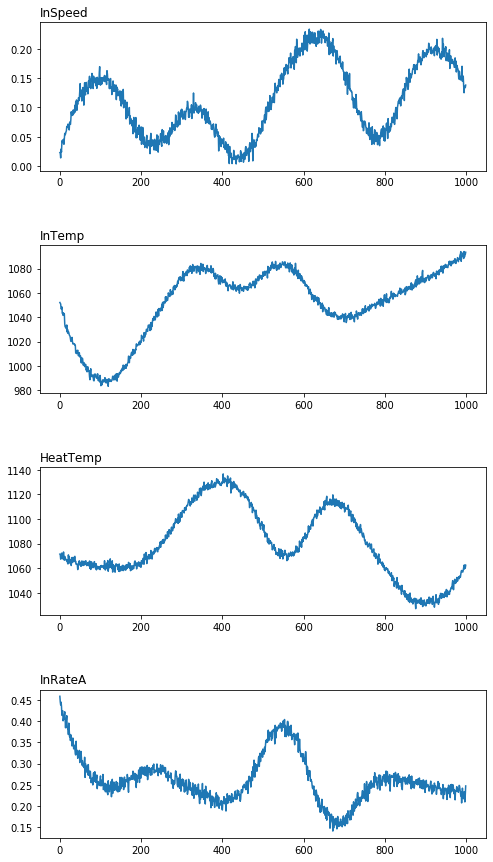

In [9]:
plt.subplots(figsize=(8,15))
plt.subplots_adjust(hspace=0.5)

for i, c in enumerate(full_vals):
    plt.subplot(4,1,1+i)
    #plt.plot(full_vals[c][0], full_vals[c][1])
    plt.plot(ftr_vals[c])
    plt.title(c, loc='left')

In [100]:
#拆分、存储数据集
split_part = [700, 240, 60]
pos = 0
for j, n in enumerate(split_part):
    with open('input_data_%s.xls'%j, 'w') as f:
        for c in FTR_COLS:
            f.write('%s\t%s\n' % (c, ','.join(['%.4f' % i for i in ftr_vals[c][pos:pos+n]])))
        pos += n